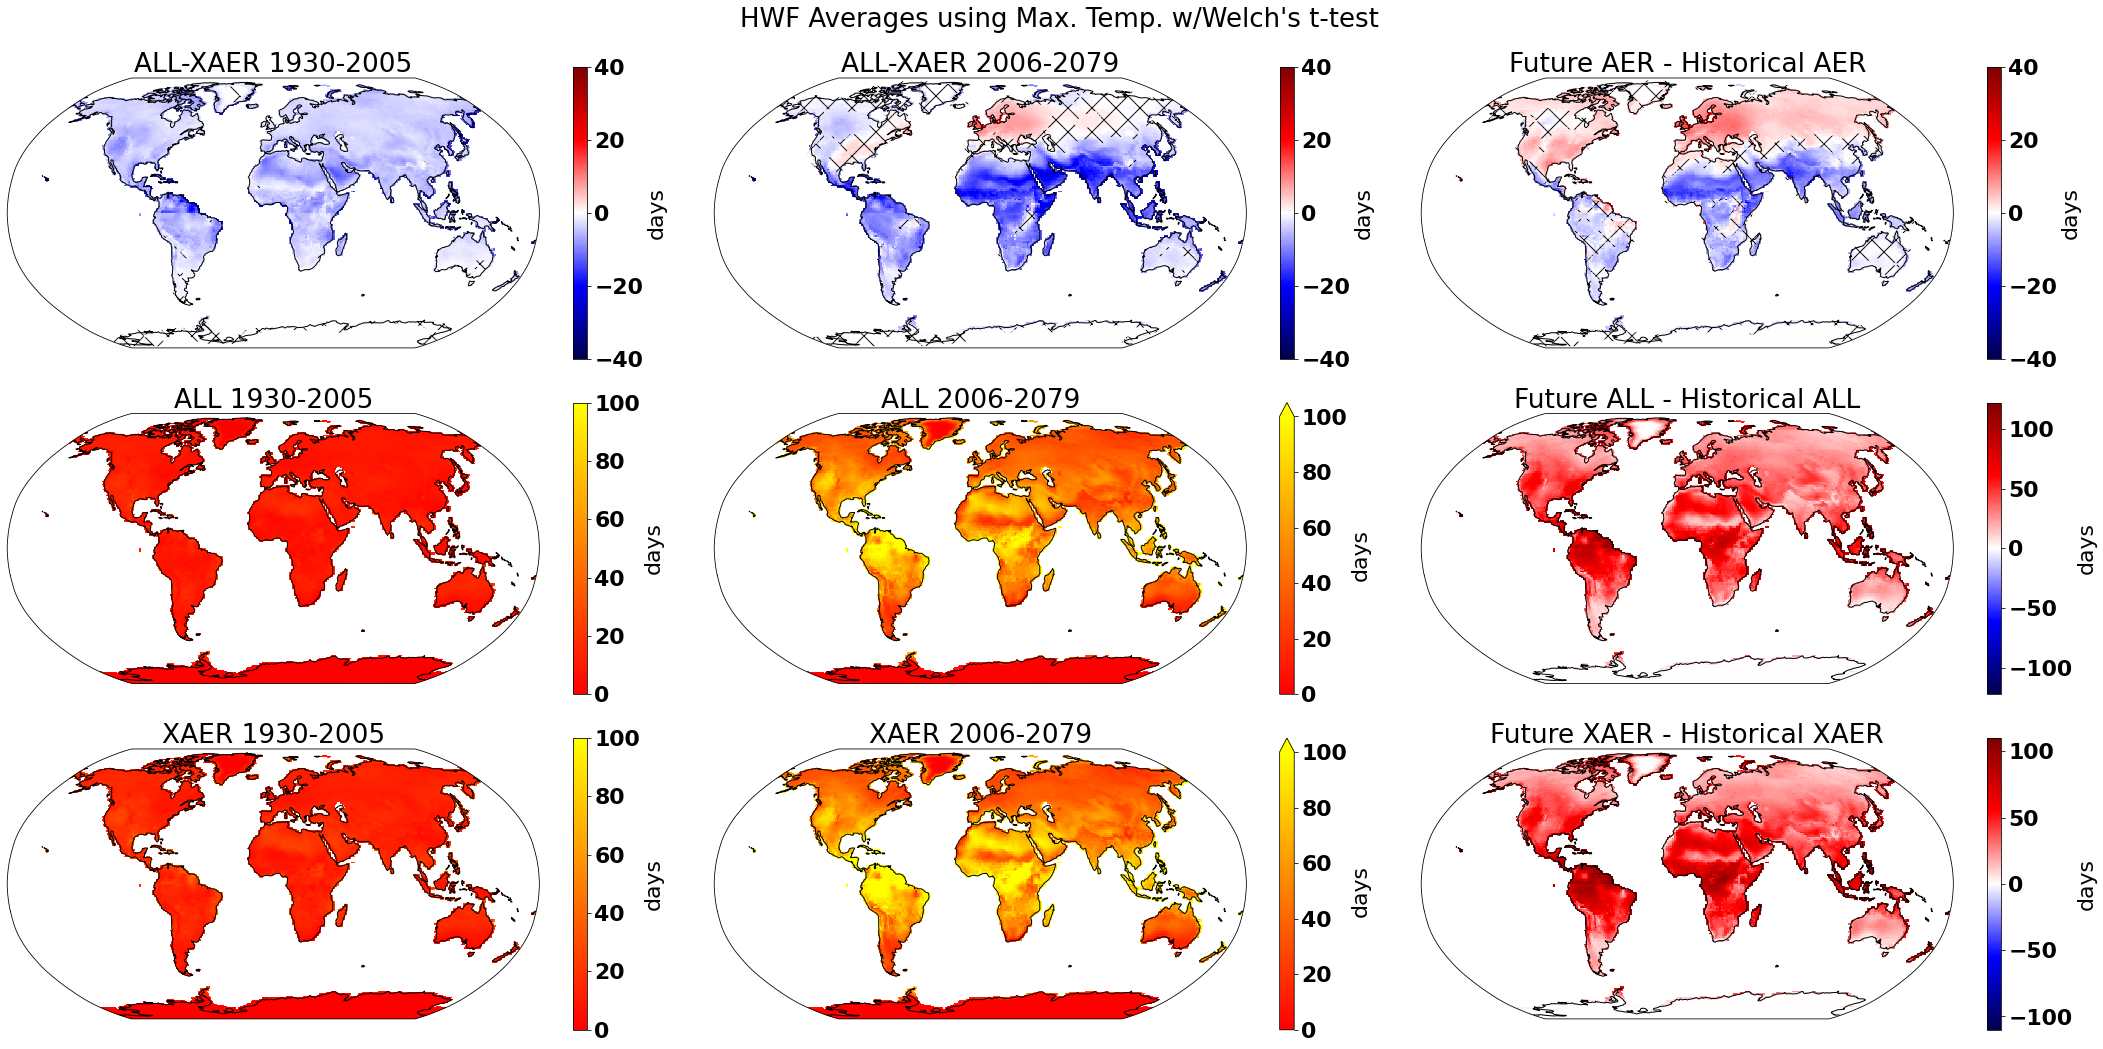

In [10]:
from paths import heat_out_trefht_tmin_members_1920_1950_CONTROL as tmin, heat_out_trefht_tmax_members_1920_1950_CONTROL as tmax, land_mask
import xarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import colors
from matplotlib import rc
import matplotlib.patches as mpatches
from analysis import t_test_mask
import numpy as np
from scipy.stats import ttest_ind


def sig_mask(all_ds, xaer_ds):
    
    def welch_t_test(all_pt, xaer_pt, lat, lon):
        # Confirmed that Sarah's modified t test is just a welches t test using my own code
        t_val, p_val = ttest_ind(all_pt, xaer_pt, equal_var=False)
        return ((lat, lon), p_val)
        
    #print("Converting to numpy array...")
    # (member, time, lat, lon)
    all_array = all_ds.values
    xaer_array = xaer_ds.values
    #print("Done.")
    
    results = []
    #print(f"Preforming test, modified={modified}")
    for lati, lat in enumerate(all_ds.lat.values):
        for loni, lon in enumerate(all_ds.lon.values):
            all_pt = all_array[0:all_ds["member"].size, 0:all_ds["time"].size, lati, loni].flatten()
            xaer_pt = xaer_array[0:xaer_ds["member"].size, 0:xaer_ds["time"].size, lati, loni].flatten()
            results.append(welch_t_test(all_pt, xaer_pt, lat, lon))
    
    if len(results) == all_min.lat.size*all_min.lon.size:
        #print("Shapes match, converting back to xarray...")
        pass
    else:
        raise RuntimeError(f'The mask size does not match the original dataset size: {len(mask)} != {all_min.lat.size*all_min.lon.size}')
    
    # Recycle ALL array
    return_array = (all_ds.mean(dim="member").mean(dim="time").load() * 0).rename("p-value")
    for index, ((lat, lon), value) in enumerate(results):
        return_array.loc[dict(lat=lat, lon=lon)] = value
    
    return return_array

exp_num = "3136"

vmin = -40
vmax = 40
cmap = "seismic"
var = "HWF"

sigmas = 2
modified = False

all_min, xghg_min, xaer_min = tmax()
land_m = xarray.open_dataset(land_mask())["__xarray_dataarray_variable__"]
all_min = xarray.open_mfdataset([path for path in all_min if exp_num in path], concat_dim="member", combine="nested")[f"{var}_tx90"].dt.days.sel(time=slice(1920,2079)).load()
xaer_min = xarray.open_mfdataset([path for path in xaer_min if exp_num in path], concat_dim="member", combine="nested")[f"{var}_tx90"].dt.days.sel(time=slice(1920,2079)).load()
ds_min = (all_min.mean(dim="member") - xaer_min.mean(dim="member")).where(land_m > 0)
ds_min = ds_min.assign_coords(lon=(((ds_min.lon + 180) % 360) - 180)).sortby('lon')

rc('font', **{'family': 'normal', 'weight': 'bold', 'size': 22})
f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(30, 15), facecolor='w', subplot_kw={'projection': ccrs.Robinson()})
f.suptitle(f"{var} Averages using Max. Temp. w/Welch's t-test ", fontsize=26)

def region_plotting(map_ax, ds, dummy):
    """
    Adds pink boxes to each map
    
    """
    edge_s = 2
    edge_c = "#F70FD8"
    edge_ls = "--"
    
    map_ax.add_patch(mpatches.Rectangle(xy=[-20, 35], width=80, height=30, fill=False, edgecolor=edge_c, linestyle=edge_ls, linewidth=edge_s, transform=ccrs.PlateCarree()))
    europe = ds.where(ds.lat>35).where(ds.lat<65).where(ds.lon>-20).where(ds.lon<60).mean(dim="lat").mean(dim="lon").load()

    map_ax.add_patch(mpatches.Rectangle(xy=[-100, 25], width=40, height=30, fill=False, edgecolor=edge_c, linestyle=edge_ls, linewidth=edge_s, transform=ccrs.PlateCarree()))
    e_na = ds.where(ds.lat>25).where(ds.lat<55).where(ds.lon>-100).where(ds.lon<-60).mean(dim="lat").mean(dim="lon").load()
    
    map_ax.add_patch(mpatches.Rectangle(xy=[-90, 10], width=35, height=-35, fill=False, edgecolor=edge_c, linestyle=edge_ls, linewidth=edge_s, transform=ccrs.PlateCarree()))
    trop_s_amer = ds.where(ds.lat>-25).where(ds.lat<10).where(ds.lon>-90).where(ds.lon<-55).mean(dim="lat").mean(dim="lon").load()
    
    map_ax.add_patch(mpatches.Rectangle(xy=[-10, 15], width=55, height=-35, fill=False, edgecolor=edge_c, linestyle=edge_ls, linewidth=edge_s, transform=ccrs.PlateCarree()))
    africa = ds.where(ds.lat>-20).where(ds.lat<15).where(ds.lon>-10).where(ds.lon<45).mean(dim="lat").mean(dim="lon").load()
    
    map_ax.add_patch(mpatches.Rectangle(xy=[65, 5], width=55, height=35, fill=False, edgecolor=edge_c, linestyle=edge_ls, linewidth=edge_s, transform=ccrs.PlateCarree()))
    se_asia = ds.where(ds.lat>20).where(ds.lat<50).where(ds.lon>95).where(ds.lon<130).mean(dim="lat").mean(dim="lon").load()
    
    return (europe, e_na, trop_s_amer, africa, se_asia)
region_avgs = {}

hist = ds_min.sel(time=slice(1930, 2005)).mean(dim="time")
hist.plot(ax=ax1, transform=ccrs.PlateCarree(), vmax=vmax, vmin=vmin, cmap=cmap)
mask1 = sig_mask(all_min.sel(time=slice(1930, 2005)), xaer_min.sel(time=slice(1930, 2005)))
mask1 = mask1.where(mask1>0.05).where(land_m>0)
ax1.set_title("ALL-XAER 1930-2005")

fut = ds_min.sel(time=slice(2006, 2079)).mean(dim="time")
fut.plot(ax=ax2, transform=ccrs.PlateCarree(), vmax=vmax, vmin=vmin, cmap=cmap)
mask2 = sig_mask(all_min.sel(time=slice(2006, 2079)), xaer_min.sel(time=slice(2006, 2079)))
mask2 = mask2.where(mask2>0.05).where(land_m>0)
ax2.set_title("ALL-XAER 2006-2079")

(fut - hist).plot(ax=ax3, transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)
ax3.set_title("Future AER - Historical AER")
mask3 = sig_mask((all_min - xaer_min).sel(time=slice(2006, 2079)),  (all_min - xaer_min).sel(time=slice(1930, 2005)))
mask3 = mask3.where(mask3>0.05).where(land_m>0)

X, Y = np.meshgrid(mask1.lon, mask1.lat)
ax1.hexbin(X.reshape(-1), Y.reshape(-1), mask1.data.reshape(-1), hatch='x', alpha=0, transform=ccrs.PlateCarree())
ax2.hexbin(X.reshape(-1), Y.reshape(-1), mask2.data.reshape(-1), hatch='x', alpha=0, transform=ccrs.PlateCarree())
ax3.hexbin(X.reshape(-1), Y.reshape(-1), mask3.data.reshape(-1), hatch='x', alpha=0, transform=ccrs.PlateCarree())

cmap = "autumn"
vmax = 100

fut = all_min.mean(dim="member").sel(time=slice(2006,2079)).mean(dim="time").where(land_m>0)
hist = all_min.mean(dim="member").sel(time=slice(1930,2005)).mean(dim="time").where(land_m>0)
hist.plot(ax=ax4, vmax=vmax, cmap=cmap, transform=ccrs.PlateCarree())
ax4.set_title("ALL 1930-2005")
fut.plot(ax=ax5, vmax=vmax, cmap=cmap, transform=ccrs.PlateCarree())
ax5.set_title("ALL 2006-2079")
(fut - hist).plot(ax=ax6, transform=ccrs.PlateCarree(), cmap="seismic")
ax6.set_title("Future ALL - Historical ALL")

fut = xaer_min.mean(dim="member").sel(time=slice(2006,2079)).mean(dim="time").where(land_m>0)
hist = xaer_min.mean(dim="member").sel(time=slice(1930,2005)).mean(dim="time").where(land_m>0)
hist.plot(ax=ax7, vmax=vmax, cmap=cmap, transform=ccrs.PlateCarree())
ax7.set_title("XAER 1930-2005")
fut.plot(ax=ax8, vmax=vmax, cmap=cmap, transform=ccrs.PlateCarree())
ax8.set_title("XAER 2006-2079")
(fut - hist).plot(ax=ax9, transform=ccrs.PlateCarree(), cmap="seismic")
ax9.set_title("Future XAER - Historical XAER")

ax1.coastlines()
ax2.coastlines()
ax3.coastlines()
ax4.coastlines()
ax5.coastlines()
ax6.coastlines()
ax7.coastlines()
ax8.coastlines()
ax9.coastlines()


f.tight_layout()